```{try_on_binder}
```

In [1]:

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None



The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


# Tutorial: Projecting a Model

In this tutorial we will show how pyMOR builds a reduced-order model by
projecting the full-order model onto a given reduced space. If you want to learn
more about building a reduced space, you can find an introduction in
{doc}`tutorial_basis_generation`.

We will start by revisiting the concept of Galerkin projection and then manually
project the model ourselves. We will then discuss offline/online decomposition of
parametric models and see how pyMOR's algorithms automatically handle building
an online-efficient reduced-order model. Along the way, we will take a look at
some of pyMOR's source code to get a better understanding of how pyMOR's components
fit together.

## Model setup

As a full-order {{ Model }}, we will use the same
{meth}`thermal block <pymor.analyticalproblems.thermalblock.thermal_block_problem>` benchmark
problem as in {doc}`tutorial_basis_generation`. In particular, we will use pyMOR's
builtin {mod}`discretization toolkit <pymor.discretizers.builtin>`
(see {doc}`tutorial_builtin_discretizer`) to construct the FOM. However, all we say
works exactly the same when a FOM of the same mathematical structure is provided
by an external PDE solver (see {doc}`tutorial_external_solver`).

Since this tutorial is also supposed to give you a better overview of pyMOR's
architecture, we will not import everything from the {mod}`pymor.basic` convenience
module but directly import all classes and methods from their original locations in
pyMOR's subpackages.

Let's build a 2-by-2 thermal block {{ Model }} as our FOM:

In [2]:
from pymor.analyticalproblems.thermalblock import thermal_block_problem
from pymor.discretizers.builtin import discretize_stationary_cg

p = thermal_block_problem((2,2))
fom, _ = discretize_stationary_cg(p, diameter=1/100)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

To get started, we take a look at one solution of the FOM for some fixed {{ parameter_values }}.

In [3]:
U = fom.solve([1., 0.1, 0.1, 1.])
fom.visualize(U)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Output()

To build the ROM, we will need a reduced space {math}`V_N` of small dimension {math}`N`.
Any subspace of the {attr}`~pymor.models.interface.Model.solution_space` of the FOM will
do for our purposes here. We choose to build a basic POD space from some random solution
snapshots.

In [4]:
from pymor.algorithms.pod import pod
from matplotlib import pyplot as plt

snapshots = fom.solution_space.empty()
for mu in p.parameter_space.sample_randomly(20):
    snapshots.append(fom.solve(mu))
basis, singular_values = pod(snapshots, modes=10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

The singular value decay looks promising:

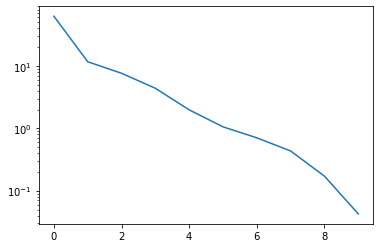

In [5]:
_ = plt.semilogy(singular_values)

## Solving the Model

Now that we have our FOM and a reduced space {math}`V_N` spanned by `basis`, we can project
the {{ Model }}. However, before doing so, we need to understand how actually
solving the FOM works. Let's take a look at what
{meth}`~pymor.models.interface.Model.solve` does:

In [6]:
from pymor.tools.formatsrc import print_source
print_source(fom.solve)

def solve(self, mu=None, input=None, return_error_estimate=False, **kwargs):
        """Solve the discrete problem for the |parameter values| `mu`.

        This method returns a |VectorArray| with a internal state
        representation of the model's solution for given
        |parameter values|. It is a convenience wrapper around
        :meth:`compute`.

        The result may be :mod:`cached <pymor.core.cache>`
        in case caching has been activated for the given model.

        Parameters
        ----------
        mu
            |Parameter values| for which to solve.
        input
            The model input. Either a |NumPy array| of shape `(self.dim_input,)`,
            a |Function| with `dim_domain == 1` and `shape_range == (self.dim_input,)`
            mapping time to input, or a `str` expression whith `t` as variable that
            can be used to instatiate an |ExpressionFunction| of this type.
            Can be `None` if `self.dim_input == 0`.
        return_error_estimate
            If `True`, also return an error estimate for the computed solution.
        kwargs
            Additional keyword arguments passed to :meth:`compute` that
            might affect how the solution is computed.

        Returns
        -------
        The solution |VectorArray|. When `return_error_estimate` is `True`,
        the estimate is returned as second value.
        """
        data = self.compute(
            solution=True,
            solution_error_estimate=return_error_estimate,
            mu=mu,
            input=input,
            **kwargs
        )
        if return_error_estimate:
            return data['solution'], data['solution_error_estimate']
        else:
            return data['solution']

This does not look too interesting. Actually, {meth}`~pymor.models.interface.Model.solve`
is just a convenience method around {meth}`~pymor.models.interface.Model.compute` which
handles the actual computation of the solution and various other associated values like
outputs or error estimates. Next, we take a look at the implemenation of
{meth}`~pymor.models.interface.Model.compute`:

In [7]:
print_source(fom.compute)

def compute(self, solution=False, output=False, solution_d_mu=False, output_d_mu=False,
                solution_error_estimate=False, output_error_estimate=False,
                output_d_mu_return_array=False, output_error_estimate_return_vector=False,
                *, mu=None, input=None, **kwargs):
        """Compute the solution of the model and associated quantities.

        This methods computes the output of the model it's internal state
        and various associated quantities for given |parameter values|
        `mu`.

        .. note::

            The default implementation defers the actual computations to
            the methods :meth:`_compute_solution`, :meth:`_compute_output`,
            :meth:`_compute_solution_error_estimate` and :meth:`_compute_output_error_estimate`.
            The call to :meth:`_compute_solution` is :mod:`cached <pymor.core.cache>`.
            In addition, |Model| implementors may implement :meth:`_compute` to
            simultaneously compute multiple values in an optimized way. The corresponding
            `_compute_XXX` methods will not be called for values already returned by
            :meth:`_compute`.

        Parameters
        ----------
        solution
            If `True`, return the model's internal state.
        output
            If `True`, return the model output.
        solution_d_mu
            If not `False`, either `True` to return the derivative of the model's
            internal state w.r.t. all parameter components or a tuple `(parameter, index)`
            to return the derivative of a single parameter component.
        output_d_mu
            If `True`, return the gradient of the model output w.r.t. the |Parameter|.
        solution_error_estimate
            If `True`, return an error estimate for the computed internal state.
        output_error_estimate
            If `True`, return an error estimate for the computed output.
        output_d_mu_return_array
            If `True`, return the output gradient as a |NumPy array|.
            Otherwise, return a dict of gradients for each |Parameter|.
        output_error_estimate_return_vector
            If `True`, return the output estimate as a |NumPy array|,
            where each component corresponds to the respective component
            of the :attr:`output_functional`.
            Otherwise, return the euclidian norm of all components.
        mu
            |Parameter values| for which to compute the values.
        input
            The model input. Either a |NumPy array| of shape `(self.dim_input,)`,
            a |Function| with `dim_domain == 1` and `shape_range == (self.dim_input,)`
            mapping time to input, or a `str` expression whith `t` as variable that
            can be used to instatiate an |ExpressionFunction| of this type.
            Can be `None` if `self.dim_input == 0`.
        kwargs
            Further keyword arguments to select further quantities that sould
            be returned or to customize how the values are computed.

        Returns
        -------
        A dict with the computed values.
        """
        # make sure no unknown kwargs are passed
        assert kwargs.keys() <= self._compute_allowed_kwargs
        assert input is not None or self.dim_input == 0

        # parse parameter values
        if not isinstance(mu, Mu):
            mu = self.parameters.parse(mu)
        assert self.parameters.assert_compatible(mu)

        # parse input and add it to the parameter values
        mu_input = Parameters(input=self.dim_input).parse(input)
        input = mu_input.get_time_dependent_value('input') if mu_input.is_time_dependent('input') else mu_input['input']
        mu = mu.with_(input=input)

        # log output
        # explicitly checking if logging is disabled saves some cpu cycles
        if not self.logging_disabled:
            self.logger.info(f'Solving {self.name} for {mu} ...')

        # first call _compute to give subclasses more

What we see is a default implementation from {class}`~pymor.models.interface.Model` that
takes care of checking the input {{ parameter_values }} `mu`, {mod}`caching <pymor.core.cache>` and
{mod}`logging <pymor.core.logger>`, but defers the actual computations to further private methods.
Implementors can directly implement {meth}`~pymor.models.interface.Model._compute` to compute
multiple return values at once in an optimized way. Our given model, however, just implements
{meth}`~pymor.models.interface.Model._compute_solution` where we can find the
actual code:

In [8]:
print_source(fom._compute_solution)

def _compute_solution(self, mu=None, **kwargs):
        return self.operator.apply_inverse(self.rhs.as_range_array(mu), mu=mu)

What does this mean? If we look at the type of `fom`,

In [9]:
type(fom)

pymor.models.basic.StationaryModel

we see that `fom` is a {{ StationaryModel }} which encodes an equation of the
form

```{math}
L(u(\mu); \mu) = F(\mu)
```

Here, {math}`L` is a linear or non-linear parametric {{ Operator }} and {math}`F` is a
parametric right-hand side vector. In {{ StationaryModel }}, {math}`L` is represented by
the {attr}`~pymor.models.basic.StationaryModel.operator` attribute. So

```
self.operator.apply_inverse(X, mu=mu)
```

determines the solution of this equation for the {{ parameter_values }} `mu` and a right-hand
side given by `X`. As you see above, the right-hand side of the equation is given by the
{attr}`~pymor.models.basic.StationaryModel.rhs` attribute.
However, while {meth}`~pymor.operators.interface.Operator.apply_inverse` expects a
{{ VectorArray }},  we see that {attr}`~pymor.models.basic.StationaryModel.rhs` is actually
an {{ Operator }}:

In [10]:
fom.rhs

NumpyMatrixOperator(<20201x1 dense>, range_id='STATE')

This is due to the fact that {{ VectorArrays }} in pyMOR cannot be parametric. So to allow
for parametric right-hand sides, this right-hand side is encoded by a linear {{ Operator }}
that maps numbers to scalar multiples of the right-hand side vector. Indeed, we see that

In [11]:
fom.rhs.source

NumpyVectorSpace(1)

is one-dimensional, and if we look at the base-class implementation of
{meth}`~pymor.operators.interface.Operator.as_range_array`

In [12]:
from pymor.operators.interface import Operator
print_source(Operator.as_range_array)

def as_range_array(self, mu=None):
        """Return a |VectorArray| representation of the operator in its range space.

        In the case of a linear operator with |NumpyVectorSpace| as
        :attr:`~Operator.source`, this method returns for given |parameter values|
        `mu` a |VectorArray| `V` in the operator's :attr:`~Operator.range`,
        such that ::

            V.lincomb(U.to_numpy()) == self.apply(U, mu)

        for all |VectorArrays| `U`.

        Parameters
        ----------
        mu
            The |parameter values| for which to return the |VectorArray|
            representation.

        Returns
        -------
        V
            The |VectorArray| defined above.
        """
        assert isinstance(self.source, NumpyVectorSpace) and self.linear
        assert self.source.dim <= as_array_max_length()
        return self.apply(self.source.from_numpy(np.eye(self.source.dim)), mu=mu)

we see all that {meth}`~pymor.operators.interface.Operator.as_range_array`
does is to apply the operator to {math}`1`. (`NumpyMatrixOperator.as_range_array`
has an optimized implementation which just converts the stored matrix to a
{{ NumpyVectorArray }}.)

Let's try solving the model on our own:

In [13]:
U2 = fom.operator.apply_inverse(fom.rhs.as_range_array(mu), mu=[1., 0.1, 0.1, 1.])

TypeError: mu is not a Mu instance. (Use parameters.parse?)

That did not work too well! In pyMOR, all parametric objects expect the
`mu` argument to be an instance of the {class}`~pymor.parameters.base.Mu`
class. {meth}`~pymor.models.interface.Model.compute` and related methods
like {meth}`~pymor.models.interface.Model.solve` are an exception: for
convenience, they accept as a `mu` argument anything that can be converted
to a {class}`~pymor.parameters.base.Mu` instance using the
{meth}`~pymor.parameters.base.Parameters.parse` method of the
{class}`~pymor.parameters.base.Parameters` class. In fact, if you look
back at the implementation of {meth}`~pymor.models.interface.Model.compute`,
you see the explicit call to {meth}`~pymor.parameters.base.Parameters.parse`.
We try again:

In [14]:
mu = fom.parameters.parse([1., 0.1, 0.1, 1.])
U2 = fom.operator.apply_inverse(fom.rhs.as_range_array(mu), mu=mu)

We can check that we get exactly the same result as from our earlier call
to {meth}`~pymor.models.interface.Model.solve`:

In [15]:
(U-U2).norm()

array([0.])

## Galerkin Projection

Now that we understand how the FOM works, we want to build a reduced-order model
which approximates the FOM solution {math}`U(\mu)` in {math}`V_N`.
To that end we call {math}`\mathbb{V}_N` the matrix that has the vectors in
`basis` as columns. The coefficients of the solution of the ROM w.r.t. these
basis vectors will be called {math}`u_N(\mu)`. We want that

```{math}
U_N := \mathbb{V}_N \cdot u_N(\mu) \approx u(\mu).
```

Substituting {math}`\mathbb{V}_N \cdot u_N(\mu)` for {math}`u(\mu)` into the equation system
defining the FOM, we arrive at:

```{math}
L(\mathbb{V}_N\cdot u_N(\mu); \mu) = F(\mu).
```

However, this is an over-determined system: we have decreased the degrees of
freedom of the solution, but did not change the number of constraints (the dimension
of {math}`F(\mu)`). So in general, this system will not have a solution.

One approach to define {math}`u_N` from this ansatz is to choose {math}`u_N`
as a minimizer of norm of the residual of the equations system, i.e. to minimize
the defect by which {math}`u_N` fails to satisfy the equations:

```{math}
u_N(\mu) := \operatorname{arg\,min}_{u \in \mathbb{R}^N} \|F(\mu) - L(\mathbb{V}_N \cdot u; \mu)\|.
```

While this is a feasible (and sometimes necessary) approach that can be realized with
pyMOR as well, we choose here an even simpler method by requiring that the residual is
orthogonal to our reduced space, i.e.

```{math}
(\mathbb{V}_{N,i},\, F(\mu) - L(\mathbb{V}_N \cdot u_N; \mu)) = 0 \qquad i=1,\ldots,N,
```

where the {math}`\mathbb{V}_{N,i}` denote the columns of {math}`\mathbb{V}_N`
and {math}`(\cdot, \cdot)` denotes some inner product on our
{attr}`~pymor.models.interface.Model.solution_space`.

Let us assume that {math}`L` is actually linear for all parameter values {math}`\mu`,
and that {math}`\mathbb{A}(\mu)` is its matrix representation. Further assume
that {math}`(\cdot, \cdot)` is the Euclidean inner product. Then we arrive at

```{math}
[\mathbb{V}_N^T \cdot \mathbb{A}(\mu) \cdot \mathbb{V}_N] \cdot u_N =
\mathbb{V}_N^T \cdot F(\mu),
```

which is a {math}`N\times N` linear equation system. In the common case that
{math}`\mathbb{A}(\mu)` is positive definite, the reduced system matrix

```{math}
\mathbb{A}_N(\mu) := \mathbb{V}_N^T \cdot \mathbb{A}(\mu) \cdot \mathbb{V}_N
```

is positive definite as well, and {math}`u_N(\mu)` is uniquely determined. We call
{math}`U_N(\mu)` the Galerkin projection of {math}`U(\mu)` onto {math}`V_N`.

You may know the concept of Galerkin projection from finite element methods. Indeed, if our
equation system comes from the weak formulation of a PDE of the form

```{math}
a(v, U(\mu); \mu) = f(v; \mu) \qquad \forall v \in V_h,
```

the matrix of the bilinear form {math}`a(\cdot, \cdot; \mu)` w.r.t. a finite element basis
is {math}`\mathbb{A}(\mu)`, and {math}`F(\mu)` is the vector representation of the linear
functional {math}`f` w.r.t. the dual finite element basis, then

```{math}
\mathbb{A}_N(\mu) \cdot u_N = \mathbb{V}_N^T \cdot F(\mu)
```

is exactly the equation system obtained from Galerkin projection of the weak PDE formulation onto
the reduced space, i.e. solving

```{math}
a(v, u_N(\mu); \mu) = f(v; \mu) \qquad \forall v \in V_N
```

for {math}`U_N(\mu) \in V_N`. As for finite element methods,
[Cea's Lemma](<https://en.wikipedia.org/wiki/Cea's_lemma>) guarantees that when {math}`a(\cdot, \cdot, \mu)`
is positive definite, {math}`U_N` will be a quasi-best approximation
of {math}`U(\mu)` in {math}`V_N`. So, if we have constructed a good reduced space {math}`V_N`, then
Galerkin projection will also give us a good ROM to actually find a good approximation in {math}`V_N`.

Let's compute the Galerkin ROM for our FOM at hand with pyMOR. To compute {math}`\mathbb{A}_N`
we use the {meth}`~pymor.operators.interface.Operator.apply2` method of `fom.operator`.
For computing the inner products {math}`\mathbb{V}_N^T \cdot F(\mu)` we can simply compute the
inner product with the `basis` {{ VectorArray }} using its {meth}`~pymor.vectorarrays.interface.VectorArray.inner`
method:

In [16]:
reduced_operator = fom.operator.apply2(basis, basis, mu=mu)
reduced_rhs = basis.inner(fom.rhs.as_range_array(mu))

Now we just need to solve the resulting linear equation system using {{ NumPy }} to obtain
{math}`u_N(\mu)`:

In [17]:
import numpy as np

u_N = np.linalg.solve(reduced_operator, reduced_rhs)
u_N

array([[-15.16166755],
       [ -1.06060498],
       [ -4.3360103 ],
       [  3.81207226],
       [  2.74026133],
       [  0.98606744],
       [ -0.1756243 ],
       [ -1.26817802],
       [  0.55510353],
       [ -0.0470637 ]])

To reconstruct the high-dimensional approximation {math}`\mathbb{V}_N \cdot u_N(\mu)`
from {math}`u_N(\mu)` we can use the {meth}`~pymor.vectorarrays.interface.VectorArray.lincomb`
method:

In [18]:
U_N = basis.lincomb(u_N.T)
U_N

NumpyVectorArray(
    [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.51308241e-04
      2.29395339e-04 8.64727182e-05]],
    NumpyVectorSpace(20201, id='STATE'))

Let's see, how good our reduced approximation is:

In [19]:
(U-U_N).norm(fom.h1_0_product) / U.norm(fom.h1_0_product)

array([0.01961789])

With only 10 basis vectors, we have achieved a relative {math}`H^1`-error of 2%.
We can also visually inspect our solution and the approximation error:

In [20]:
fom.visualize((U, U_N, U-U_N), separate_colorbars=True)

Output()

## Building the ROM

So far, we have only constructed the ROM in the form of {{ NumPy }} data structures:

In [21]:
type(reduced_operator)

numpy.ndarray

To build a proper pyMOR {{ Model }} for the ROM, which can be used everywhere a {{ Model }} is
expected, we first wrap these data structures as pyMOR {{ Operators }}:

In [22]:
from pymor.operators.numpy import NumpyMatrixOperator

reduced_operator = NumpyMatrixOperator(reduced_operator)
reduced_rhs = NumpyMatrixOperator(reduced_rhs)

Galerkin projection does not change the structure of the model. So the ROM should again
be a {{ StationaryModel }}. We can construct it easily as follows:

In [23]:
from pymor.models.basic import StationaryModel
rom = StationaryModel(reduced_operator, reduced_rhs)
rom

StationaryModel(
    NumpyMatrixOperator(<10x10 dense>),
    NumpyMatrixOperator(<10x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(10)),
    products={})

Let's check if it works as expected:

In [24]:
u_N2 = rom.solve()
u_N.T - u_N2.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We get exactly the same result, so we have successfully built a pyMOR ROM.

## Offline/Online Decomposition

There is one issue however. Our ROM has lost the parametrization since we
have assembled the reduced-order system for a specific set of
{{ parameter_values }}:

In [25]:
print(fom.parameters)
print(rom.parameters)

{diffusion: 4}
{}


Solving the ROM for a new `mu` would mean to build a new ROM with updated
system matrix and right-hand side. However, if we compare the timings,

In [26]:
from time import perf_counter

tic = perf_counter()
fom.solve(mu)
toc = perf_counter()
fom.operator.apply2(basis, basis, mu=mu)
basis.inner(fom.rhs.as_range_array(mu))
tac = perf_counter()
rom.solve()
tuc = perf_counter()
print(f'FOM:          {toc-tic:.5f} (s)')
print(f'ROM assemble: {tac-toc:.5f} (s)')
print(f'ROM solve:    {tuc-tac:.5f} (s)')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

FOM:          0.07555 (s)
ROM assemble: 0.01072 (s)
ROM solve:    0.00132 (s)


we see that we lose a lot of our speedup when we assemble the ROM
(which involves a lot of full-order dimensional operations).

To solve this issue we need to find a way to pre-compute everything we need
to solve the ROM once-and-for-all for all possible {{ parameter_values }}. Luckily,
the system operator of our FOM has a special structure:

In [27]:
fom.operator

LincombOperator(
    (NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_3')),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')),
    name='ellipticOperator')

We see that `operator` is a {{ LincombOperator }}, a linear combination of {{ Operators }}
with coefficients that may either be a number or a parameter-dependent number,
called a {{ ParameterFunctional }} in pyMOR. In our case, all
{attr}`~pymor.operators.constructions.LincombOperator.operators` are
{{ NumpyMatrixOperators }}, which themselves don't depend on any parameter. Only the
{attr}`~pymor.operators.constructions.LincombOperator.coefficients` are
parameter-dependent.  This allows us to easily build a parametric ROM that no longer
requires any high-dimensional operations for its solution by projecting each
{{ Operator }} in the sum separately:

In [28]:
reduced_operators = [NumpyMatrixOperator(op.apply2(basis, basis))
                     for op in fom.operator.operators]

We could instantiate a new {{ LincombOperator }} of these `reduced_operators` manually.
An easier way is to use the {meth}`~pymor.core.base.ImmutableObject.with_` method,
which allows us to create a new object from a given {{ ImmutableObject }} by replacing
some of its attributes by new values:

In [29]:
reduced_operator = fom.operator.with_(operators=reduced_operators)

The right-hand side of our problem is non-parametric,

In [30]:
fom.rhs.parameters

Parameters({})

so we don't need to do anything special about it. We build a new ROM,

In [31]:
rom = StationaryModel(reduced_operator, reduced_rhs)

which now depends on the same {{ Parameters }} as the FOM:

In [32]:
rom.parameters

Parameters({diffusion: 4})

We check that our new ROM still computes the same solution:

In [33]:
u_N3 = rom.solve(mu)
u_N.T - u_N3.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Let's see if our new ROM is actually faster than the FOM:

In [34]:
tic = perf_counter()
fom.solve(mu)
toc = perf_counter()
rom.solve(mu)
tac = perf_counter()
print(f'FOM: {toc-tic:.5f} (s)')
print(f'ROM: {tac-toc:.5f} (s)')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

FOM: 0.07732 (s)
ROM: 0.00154 (s)


You should see a significant speedup of around two orders of magnitude.
In model order reduction, problems where the {{ parameter_values }} only enter
as linear coefficients are called parameter separable. Many real-life
application problems are actually of this type, and as you have seen in this
section, these problems admit an *offline/online decomposition* that
enables the *online efficient* solution of the ROM.

For problems that do not allow such an decomposition and also for non-linear
problems, more advanced techniques are necessary such as
{mod}`empiricial interpolation <pymor.algorithms.ei>`.

## Letting pyMOR do the work

So far we completely built the ROM ourselves. While this may not have been
very complicated after all, you'd expect a model order reduction library
to do the work for you and to automatically keep an eye on proper
offline/online decomposition.

In pyMOR, the heavy lifting is handled by the
{meth}`~pymor.algorithms.projection.project` method, which is able to perform
a Galerkin projection, or more general a Petrov-Galerkin projection, of any
pyMOR {{ Operator }}. Let's see, how it works:

In [35]:
from pymor.algorithms.projection import project

reduced_operator = project(fom.operator, basis, basis)
reduced_rhs      = project(fom.rhs,      basis, None )

The arguments of {meth}`~pymor.algorithms.projection.project` are the {{ Operator }}
to project, a reduced basis for the {attr}`~pymor.operators.interface.Operator.range`
(test) space and a reduced basis for the {attr}`~pymor.operators.interface.Operator.source`
(ansatz) space of the {{ Operator }}. If no projection for one of these spaces shall be performed,
`None` is passed.  Since we are performing Galerkin-projection, where test space into
which the residual is projected is the same as the ansatz space in which the solution
is determined, we pass `basis` twice when projecting `fom.operator`. Note that
`fom.rhs` only takes scalars as input, so we do not need to project anything in the ansatz space.

If we check the result,

In [36]:
reduced_operator

LincombOperator(
    (NumpyMatrixOperator(<10x10 dense>, name='boundary_part'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_0'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_1'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_2'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_3')),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')),
    name='ellipticOperator')

we see, that pyMOR indeed has taken care of projecting each individual {{ Operator }}
of the linear combination. We check again that we have built the same ROM:

In [37]:
rom = StationaryModel(reduced_operator, reduced_rhs)
u_N4 = rom.solve(mu)
u_N.T - u_N4.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

So how does {meth}`~pymor.algorithms.projection.project` actually work? Let's take
a look at the source:

In [38]:
print_source(project)

def project(op, range_basis, source_basis, product=None):
    """Petrov-Galerkin projection of a given |Operator|.

    Given an inner product `( ⋅, ⋅)`, source vectors `b_1, ..., b_N`
    and range vectors `c_1, ..., c_M`, the projection `op_proj` of `op`
    is defined by ::

        [ op_proj(e_j) ]_i = ( c_i, op(b_j) )

    for all i,j, where `e_j` denotes the j-th canonical basis vector of R^N.

    In particular, if the `c_i` are orthonormal w.r.t. the given product,
    then `op_proj` is the coordinate representation w.r.t. the `b_i/c_i` bases
    of the restriction of `op` to `span(b_i)` concatenated with the
    orthogonal projection onto `span(c_i)`.

    From another point of view, if `op` is viewed as a bilinear form
    (see :meth:`apply2`) and `( ⋅, ⋅ )` is the Euclidean inner
    product, then `op_proj` represents the matrix of the bilinear form restricted
    to `span(b_i) / span(c_i)` (w.r.t. the `b_i/c_i` bases).

    How the projection is realized will depend on the given |Operator|.
    While a projected |NumpyMatrixOperator| will
    again be a |NumpyMatrixOperator|, only a generic
    :class:`~pymor.operators.constructions.ProjectedOperator` can be returned
    in general. The exact algorithm is specified in :class:`ProjectRules`.

    Parameters
    ----------
    range_basis
        The vectors `c_1, ..., c_M` as a |VectorArray|. If `None`, no
        projection in the range space is performed.
    source_basis
        The vectors `b_1, ..., b_N` as a |VectorArray| or `None`. If `None`,
        no restriction of the source space is performed.
    product
        An |Operator| representing the inner product.  If `None`, the
        Euclidean inner product is chosen.

    Returns
    -------
    The projected |Operator| `op_proj`.
    """
    assert source_basis is None or source_basis in op.source
    assert range_basis is None or range_basis in op.range
    assert product is None or product.source == product.range == op.range

    rb = product.apply(range_basis) if product is not None and range_basis is not None else range_basis

    try:
        return ProjectRules(rb, source_basis).apply(op)
    except NoMatchingRuleError:
        op.logger.warning('Using inefficient generic projection operator')
        return ProjectedOperator(op, range_basis, source_basis, product)

We see there is error checking and some code to handle the optional `product` {{ Operator }}
used to project into the reduced {attr}`~pymor.operators.interface.Operator.range` space.
The actual work is done by the {meth}`~pymor.algorithms.rules.RuleTable.apply` method
of the `ProjectRules` object.

`ProjectRules` is a {{ RuleTable }}, an ordered list of conditions with corresponding actions.
The list is traversed from top to bottom, and the action of the first matching condition is
executed. These {{ RuleTables }} can also be modified by the user to customize the behavior
of an algorithm for a specific application. We will not go into the details of defining
or modifying a {{ RuleTable }} here, but we will look at the rules of `ProjectRules` by looking
at its string representation:

In [39]:
from pymor.algorithms.projection import ProjectRules
ProjectRules

Pos  Match Type  Condition                      Action Name / Action           
---  ----------  -----------------------------  -------------------------------
                                                Description                    
0    ALWAYS      None                           no_bases                       
1    CLASS       ZeroOperator                   ZeroOperator                   
2    CLASS       ConstantOperator               ConstantOperator               
3    GENERIC     linear and not parametric      apply_basis                    
4    CLASS       ConcatenationOperator          ConcatenationOperator          
5    CLASS       AdjointOperator                AdjointOperator                
6    CLASS       EmpiricalInterpolatedOperator  EmpiricalInterpolatedOperator  
7    CLASS       AffineOperator                 AffineOperator                 
8    CLASS       LincombOperator                LincombOperator                
9    CLASS       SelectionOperator      

In the case of `fom.operator`, which is a {{ LincombOperator }}, the rule with index 8 will
be the first matching rule. We can take a look at it:

In [40]:
assert ProjectRules.rules[8].action_description == 'LincombOperator'

In [41]:
ProjectRules.rules[8]

@match_class(LincombOperator)
    def action_LincombOperator(self, op):
        return self.replace_children(op).with_(solver_options=None)

The implementation of the action for {{ LincombOperators }} uses the
{meth}`~pymor.algorithms.rules.RuleTable.replace_children` method of {{ RuleTable }},
which will recursively apply `ProjectionRules` to all
{meth}`children <pymor.algorithms.rules.RuleTable.get_children>` of the
{{ Operator }}, collect the results and then return a new {{ Operator }} where
the children have been replaced by the results of the applications of the
{{ RuleTable }}. Here, the {meth}`children <pymor.algorithms.rules.RuleTable.get_children>`
of an {{ Operator }} are all of its attribute that are either {{ Operators }} or lists or dicts
of {{ Operators }}.

In our case, `ProjectRules` will be applied to all {{ NumpyMatrixOperators }} held by
`fom.operator`. These are linear, non-parametric operators, for which rule 3
will apply:

In [42]:
assert ProjectRules.rules[3].action_description == 'apply_basis'

In [43]:
ProjectRules.rules[3]

@match_generic(lambda op: op.linear and not op.parametric, 'linear and not parametric')
    def action_apply_basis(self, op):
        range_basis, source_basis = self.range_basis, self.source_basis
        if source_basis is None:
            try:
                V = op.apply_adjoint(range_basis)
            except NotImplementedError:
                raise RuleNotMatchingError('apply_adjoint not implemented')
            if isinstance(op.source, NumpyVectorSpace):
                from pymor.operators.numpy import NumpyMatrixOperator
                return NumpyMatrixOperator(V.to_numpy(), source_id=op.source.id, name=op.name)
            else:
                from pymor.operators.constructions import VectorArrayOperator
                return VectorArrayOperator(V, adjoint=True, name=op.name)
        else:
            if range_basis is None:
                V = op.apply(source_basis)
                if isinstance(op.range, NumpyVectorSpace):
                    from pymor.operators.numpy import NumpyMatrixOperator
                    return NumpyMatrixOperator(V.to_numpy().T, range_id=op.range.id, name=op.name)
                else:
                    from pymor.operators.constructions import VectorArrayOperator
                    return VectorArrayOperator(V, adjoint=False, name=op.name)
            else:
                from pymor.operators.numpy import NumpyMatrixOperator
                return NumpyMatrixOperator(op.apply2(range_basis, source_basis), name=op.name)

This action has special cases for all possible combinations of given or not-given
{attr}`~pymor.operators.interface.Operator.range` and {attr}`~pymor.operators.interface.Operator.source`
bases. In our case, the `else` block of the second `else` block applies,
where we see our familiar {meth}`~pymor.operators.interface.Operator.apply2` call.

If you look at the rules of `ProjectRules` again, you see that
{meth}`~pymor.algorithms.projection.project` can handle many more cases.
If all rules fail, a `NoMatchingRuleError` will be raised, in which case,
{meth}`~pymor.algorithms.projection.project` will return a
{class}`~pymor.operators.constructions.ProjectedOperator`, which just stores the
projection bases and performs the projection for each call to the {{ Operator }} interface
methods. Thus, even when offline/online decomposition fails, still a mathematically correct
representation of the projected {{ Operator }} is returned to allow testing the approximation
quality of the ROM before taking care of online efficiency in a later step.

## Using Reductors

Instead of projecting each {{ Operator }} of our FOM separately and then instantiating
the ROM with the projected {{ Operators }}, we can use a {mod}`reductor <pymor.reductors>`,
which does all the work for us. For a simple Galerkin projection of a {{ StationaryModel }},
we can use {class}`~pymor.reductors.basic.StationaryRBReductor`:

In [44]:
from pymor.reductors.basic import StationaryRBReductor

reductor = StationaryRBReductor(fom, basis)
rom = reductor.reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Again, we get the same ROM as before:

In [45]:
u_N5 = rom.solve(mu)
u_N.T - u_N5.to_numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

As an additional feature, {meth}`~pymor.reductors.basic.StationaryRBReductor.reduce`
allows to project the model onto a smaller dimensional subspace of {math}`V_N` by
extracting the ROM from a previously computed ROM for the full {math}`V_N`. This
is useful, in particular, when assessing the ROM for different basis sizes. The
actual projection is handled in the
{meth}`~pymor.reductor.basic.StationaryRBReductor.project_operators` method,
where we can find some well-known code:

In [46]:
print_source(reductor.project_operators)

def project_operators(self):
        fom = self.fom
        RB = self.bases['RB']
        projected_operators = {
            'operator':          project(fom.operator, RB, RB),
            'rhs':               project(fom.rhs, RB, None),
            'products':          {k: project(v, RB, RB) for k, v in fom.products.items()},
            'output_functional': project(fom.output_functional, None, RB)
        }
        return projected_operators

We see that the reductor also takes care of projecting output functionals and
inner products associated with the {{ Model }}. The construction of the ROM from
the projected operators is performed by a separate method:

In [47]:
print_source(reductor.build_rom)

def build_rom(self, projected_operators, error_estimator):
        return StationaryModel(error_estimator=error_estimator, **projected_operators)

More advanced reductors, such as {class}`~pymor.reductors.coercive.CoerciveRBReductor`
also assemble an a posteriori error estimator for the model order reduction error.
In the case of {class}`~pymor.reductors.basic.StationaryRBReductor`, however,
`error_estimator` is always `None`.

Reductors also allow to compute {math}`U_N(\mu)` from {math}`u_N(\mu)` using
the {meth}`~pymor.reductors.basic.StationaryRBReductor.reconstruct` method:

In [48]:
U_N5 = reductor.reconstruct(u_N5)
(U_N - U_N5).norm()

array([0.])

Again, if we look at the source code, we see a familiar expression:

In [49]:
print_source(reductor.reconstruct)

def reconstruct(self, u, basis='RB'):
        """Reconstruct high-dimensional vector from reduced vector `u`."""
        return self.bases[basis][:u.dim].lincomb(u.to_numpy())

Download the code:
{download}`tutorial_projection.md`
{nb-download}`tutorial_projection.ipynb`